# Mood-RL Demonstrations

## Section 1: Summarizing Eldar & Niv (2015)

This section provides an overview of [Eldar & Niv (2015)](https://www.nature.com/articles/ncomms7149).

### Reinforcement Learning Model
In traditional reinforcement learning models, the expected value ($v$) of a stimulus is updated according to a reward prediction error ($\delta$), which reflects the difference between the actual reward obtained ($r$) and the expected value ($\delta = r - v$). This simple framework has proved successful in explaining a wide range of behavioral and neural data. 

To account for effects of mood on valuation, the model is modified to compute predictions errors with respect to *perceived reward* rather than actual reward: 

> $\delta = r_\text{perceived} - v$

where perceived reward ($r_\text{perceived}$) is different from actual reward in that it reflects the biasing effect of mood ($m$):

> $r_\text{perceived} = r \cdot f^m$

Here, $m \in (-1,1)$ where a good mood is indicated by $0 < m < 1$, and a bad mood is indicated by $-1 < m < 0$). $f$ is a positive constant that indicates the direction and extent of the mood bias. If $f=1$, moos does not bias the perception of reward. If $f>1$, mood exerts positive feedback as reward is perceived as larger in a good mood and smaller in a bad mood. Conversely, if $0 < f < 1$, mood exerts negative feedback as reward is perceived as smaller in a good mood and larger in a bad mood. 

To model the effects of unexpected outcomes on mood, mood is assumed to reflect recent prediction-error history ($h$), tracked using a step-size parameters $\eta_h$:

> $h = h + \eta_h (\delta - h)$

and is constrained to -1 and 1 by a sigmoid function:

> $m = \text{tanh} \ h$

Similar to traditional reinforcement learning models, expected values are updated after every trial according to the reward prediction error with a step-size (learning rate) parameter $\eta_v$:

> $v = v + \eta_v \delta$

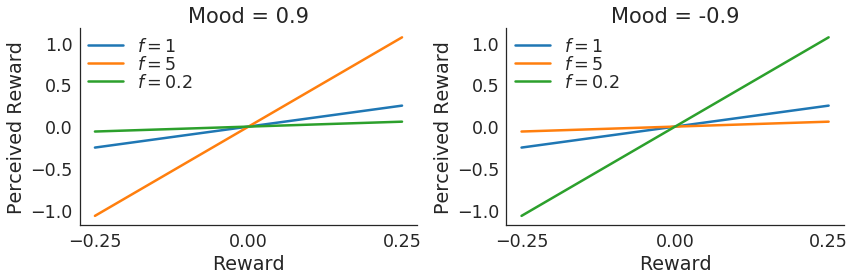

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Define bias function and rewards.
bias = lambda x, f, m: x * f ** m
reward = np.linspace(-0.25, 0.25, 101)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot.
for ax, m in zip(axes, [0.9, -0.9]):
    
    for f in [1, 5, 0.2]:
        
        ax.plot(reward, bias(reward, f, m), lw=2.5, label=r'$f = %s$' %f)
    
    ax.set(xticks=np.linspace(reward.min(),reward.max(),3), xlabel='Reward',
           ylabel='Perceived Reward', title='Mood = %s' %m)
    ax.legend(loc=2, borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

**Figure 1:** Hypothesized effect of mood on reward valuation. In the proposed reinforcement learning model, mood impacts learning through biasing reward valuation. The extent of bias is contingent on mood, $m \in (-1,1)$, and a bias parameter, $f \in (0,\infty)$. When mood is positive (left), agents with bias $f > 1$ exhibit exaggerated reward perception (i.e. $r_{perceived} > r$) whereas agents with bias $f < 1$ exhibit damped  reward perception (i.e. $r_{perceived} < r$). When mood is negative (right), the converse is true. Thus, agents with mood bias, $f \neq 1$, exhibit opposite effects when the sign of mood reverses.

### Results
**Behavioral Results**
- Wheel of Fortune (WoF) draw significantly affected participants' self-reported mood between the first and second blocks. A win increased mood, whereas a loss decreased mood.
- Wheel of Fortune draw significantly increased pupil diameter (a proxy for emotional arousal) for both wins and losses. 
- The Hypomanic Personality Scale (HPS) correlated with the absolute magnitude of post-/pre-WoF mood change.
- Participants with high HPS scores preferred slot machines in the proceeding block following a WoF win and those in the preceding following a WoF loss. This effect was not observed for participants with low HPS scores.
- Participants subjective estimates of slot machine reward probability was not altered by the WoF manipulation, consistent with the hypothesis that the behavioural bias reflected biased perception of the subjective value of reward.

**fMRI Results**
- Higher HPS score was associated with stronger BOLD responses in the striatum to rewards in the second game for participants who won the WoF, and weaker responses to rewards for participants who lost.
- Similar results were observed in the ventromedial prefrontal cortex.
- This effect was not observed for the appearance of task stimuli suggesting this was not an effect due to a general effect of emotional state on BOLD responses (e.g. arousal, attention).

**Modeling Results**
- The behavior and mood evolutions of participants with high HPS scores was best predicted by the full mood model as compared to the 'no mood' model and the 'no mood bias' model.
- The behavior and mood evolutions of participants with low HPS scores was equally well predicted by the full mood and 'no mood bias' models. Both models outperformed the 'no mood model'.
- A stronger mood bias ($f$) was correlated positively correlated with the HPS scores.
- Trial-by-trial predictors of the full mood model were more correlated with striatal activity than the other models.  
- The predicted mood from the full mood model was correlated with the observed moods of the participants.

## Section 2: Simulations

This section demonstrates through simulation the effects of different sets of model parameters on task performance.

### Task Design
Briefly, the task involved participants requiring to learn the reward probabilities of three slot machines. The slot machines yielded reward 20%, 40%, and 60% of the time, respectively. On every trial, participants were presented two of the slot machines and were instructed to select the one that they thought was more likely to return reward. Participants completed three blocks of this task with 42 trials per block. 

Of relevance to simulating task data are the following four features:

1. **Slot machine comparison balance:** trial types are balanced within block. In other words, trials wherein 20% and 40% probability machines are compared are presented the same number of times as trials wherein 20% and 60% probability machines are compared.
2. **Within-subject trial randomization:** trial presentation order are randomized within block. In other words, the likelihood of observing any pair of trials (e.g. *20% vs. 40% probability* then *20% vs. 60% probability*) is approximately equal across participants. Within participants, this balancing is not guaranteed. 
3. **Between-subject trial randomization:** trials are randomized across participants. In other words, every participant will observe a unique order of presented trials. 
4. **Outcome randomization:** rewards are truly randomized. In other words, though the average reward probability of each machine across participants is as designed (i.e. 20%, 40%, 60%), there is variability within participants' experience (e.g. 15%, 45%, 65%).

### Establishing a baseline 
To understand how mood bias affects learning, we must first understand how the canonical reinforcement learning parameters, inverse temperature ($\beta$) and learning rate ($\eta$), impact performance on the slot machine task. In this first segment, we show the range of behavioral performance when bias is absent ($f = 1$). 

For all simulated agents, performance is quantified by the fraction of optimal decisions made, where optimality is defined by choosing the slot machine with objectively higher reward probability. We set as a benchmark for good performance reaching 80% optimal decisions over the course of learning. This is similar to what is actually observed in humans performing this task (see *results_behavior* for details).

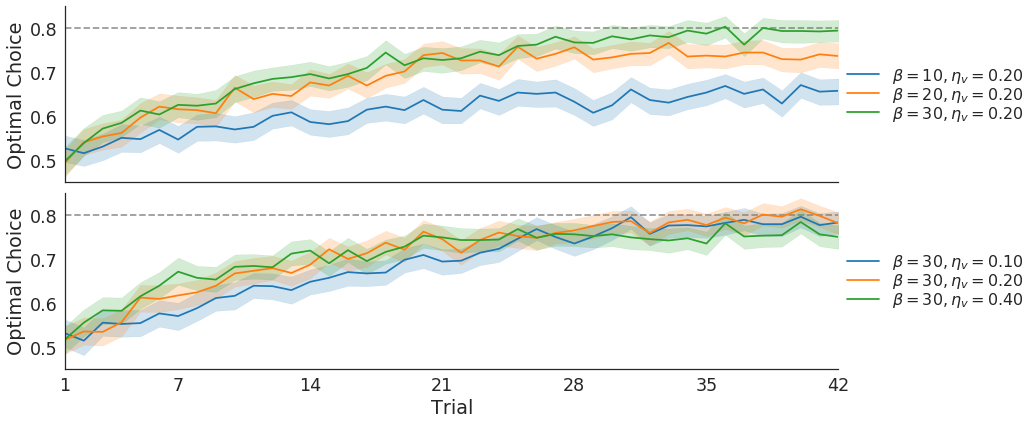

In [2]:
from scripts.simulations import MoodyAgent, DataFrame3d, optimal_choice, slot_machine_game

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define agent paramters (beta, eta_v, eta_h, f).
parameters = [[10, 0.20, 0, 1],
              [20, 0.20, 0, 1],
              [30, 0.20, 0, 1],
              
              [30, 0.10, 0, 1],
              [30, 0.20, 0, 1],
              [30, 0.40, 0, 1]]

## Initial values.
Q = 0.0

## Task parameters.
probabilities = (0.2, 0.4, 0.6)
reward = 0.25
n_trials = 42

## Simulation parameters.
n_simulations = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
choices = np.zeros((n_simulations, len(parameters), n_trials))

## Main loop.
for i in range(n_simulations):
    
    ## Simulate slot machine game.
    X, R = slot_machine_game(n_trials=n_trials, probabilities=probabilities, reward=reward)

    for j, params in enumerate(parameters):

        ## Initialize agent.
        agent = MoodyAgent(*params)
    
        ## Play block of slot machine game.
        Y, _ = agent.simulate(X, R, Q=Q)

        ## Compute optimal choices.
        choices[i,j] = optimal_choice(Y, X)

## Convert choices/moods to DataFrame.
fmt = r'$\beta = %s, \eta_v = %0.2f$'
df1 = DataFrame3d(choices[:,:3], major_axis=[fmt %(p[0],p[1]) for p in parameters[:3]])
df2 = DataFrame3d(choices[:,3:], major_axis=[fmt %(p[0],p[1]) for p in parameters[3:]])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas. 
fig, axes = plt.subplots(2,1,figsize=(12,6))
palette = sns.color_palette(n_colors=3)

## Plot optimal choice.
for ax, data in zip(axes, [df1, df2]):
    sns.lineplot('minor', 'value', 'major', data=data, palette=palette, ax=ax)
    ax.hlines(0.8, 0, n_trials-1, linestyle='--', alpha=0.4, zorder=0)
    ax.set(xlim=(0,n_trials-1), xticks=[], xlabel='', ylim=(0.45, 0.85), 
           yticks=[0.5,0.6,0.7,0.8], ylabel='Optimal Choice')
    ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), fontsize=16, borderpad=0, labelspacing=0)

xticks = np.insert(np.arange(7,43,7),0,1)
ax.set(xticks=xticks-1, xticklabels=xticks, xlabel='Trial')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Performance of canonical RL agents at the slot machine task. RL agents behavior were dictated by two parameters: inverse temperature ($\beta$) and learning rate ($\eta_v$). When the inverse temperature increases (top), performance increases. Human-level performance (70-80%) is achieved at approximately $\beta \geq 20$. Learning progresses more quickly as the learning rate increases (top). Interestingly, as the learning rate increases more, performance begins to plateau and possibly decrease ($\eta_v = 0.40$).

### Mood and RPEs
In the proposed mood-bias RL model, reward perception is biased by mood but mood is reciprocally biased the history of received rewards. To understand the model then, it is necessary to understand how mood evolves with learning. 

We demonstrate the relationship between reward, mood ($m$), and the history parameter ($\eta_h$) in a simplified task where an agent receives a \$0.25 reward on every trial. For simplicity, mood bias is absent ($f=1$) so that mood cannot have a reciprocal effect on learning.

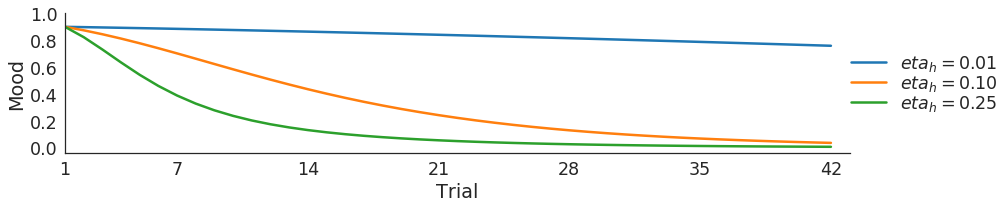

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define agent parameters.
eta_h = [0.01, 0.1, 0.25]
M = 0.9 # Initial mood.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,3))

## Task parameters.
X = np.zeros(42, dtype=int).reshape(-1,1)
R = np.ones_like(X) * 0.25
    
## Iteratively generate moods.
for p in eta_h:
    
    ## Define agent.
    agent = MoodyAgent(beta=20, eta_v=0.1, eta_h=p, f=1)
    
    ## Simulate mood.
    _, mood = agent.simulate(X, R, M=M)
    
    ## Plot.
    ax.plot(mood, lw=2.5, label=r'$eta_h = %0.2f$' %p)
    
## Add info.
ax.set(xlim=(0, X.size), xticks=xticks-1, xticklabels=xticks, xlabel='Trial', 
       yticks=np.linspace(0,1,6), ylabel='Mood')
ax.legend(loc=7, bbox_to_anchor=(1.20,0.5),  borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

**Figure 3:** Simulated effects of reward history on mood. Through a trivial example (i.e. constant reward of \$0.25),  effect of the reward history parameter, $\eta_h$, is clearly observed. Larger values of $\eta_h$ translates to higher weighting of recent RPEs. This translates to a prediction that, in volatile environments, mood will be more variable if $\eta_h$ is high but remain stable if $\eta_h$ is low.

### Dynamic interaction of mood and learning
Above we presented an example where mood bias was absent ($f=1$). When mood bias is present ($f\neq1$), however, mood can bias reward perception, thereby altering reward prediction errors (RPEs). Alterations in RPEs can then in turn impact mood, thereby giving rise to a dynamical system. 

We highlight the complexity of behavior that can arise using again the simplistic scenario from above, i.e. constant reward of 10.

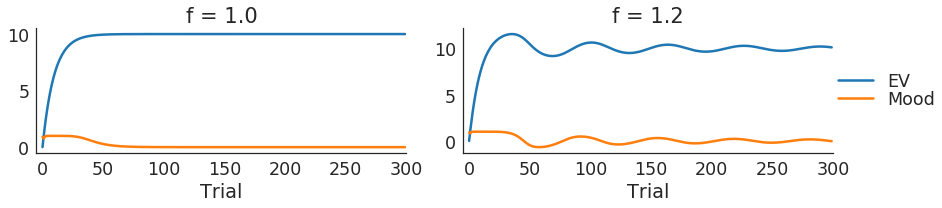

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Agent parameters.
parameters = [[10, 0.1, 0.1, 1.0],
              [10, 0.1, 0.1, 1.2]]
m = 0.9

## Task parameters.
R = np.ones(300) * 10

## Preallocate space.
Q = np.zeros((R.size, len(parameters)))
h = np.zeros_like(Q)
M = np.zeros_like(Q)
M[0] += m

## Simulate data.
for j, params in enumerate(parameters):

    ## Unpack parameters.
    beta, eta_v, eta_h, f = params

    for i in np.arange(R.size-1):
        
        ## Compute reward prediction error.
        delta = (f ** M[i,j]) * R[i] - Q[i,j]
        
        ## Update expectations.
        Q[i+1,j] = Q[i,j] + eta_v * delta

        ## Update mood.
        h[i+1,j] = h[i,j] + eta_h * (delta - h[i,j])
        M[i+1,j] = np.tanh(h[i+1,j])
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))

for ax, q, m, f in zip(axes, Q.T, M.T, np.array(parameters)[:,-1]):
    
    ## Plot expectations / mood.
    ax.plot(q, lw=2.5, label='EV')
    ax.plot(m, lw=2.5, label='Mood')
    
    ## Add info.
    ax.set(xlim=(-5,300), xlabel='Trial', title='f = %s' %f)
    
## Add legend.
ax.legend(loc=7, bbox_to_anchor=(1.3,0.5),  borderpad=0, labelspacing=0)
    
sns.despine()
plt.tight_layout()

**Figure 4:** Simulations of the interaction between learning and mood using a reinforcement learning model. The model was repeatedly exposed to the same outcome of $r = 10$ for 300 iterations for each setting of $f$, the parameter mediating the effect of mood on perception of reward. (Left) With f = 1 (no mood bias), the expected value (EV, blue) converged quickly to the true value and mood (orange) remained stable. (Right) With f = 1.2 (perceived reward positively biased by mood), learned value as well as mood oscillated and did not converge.

### Mood bias on performance
The mood-bias RL model can clearly generate complex learning behaviors. But what effect does it have on task performance? We demonstrate below that, under certain conditions (such as those chosen in the manuscript), the mood-bias RL model can outperform the canonical two-parameter RL model.

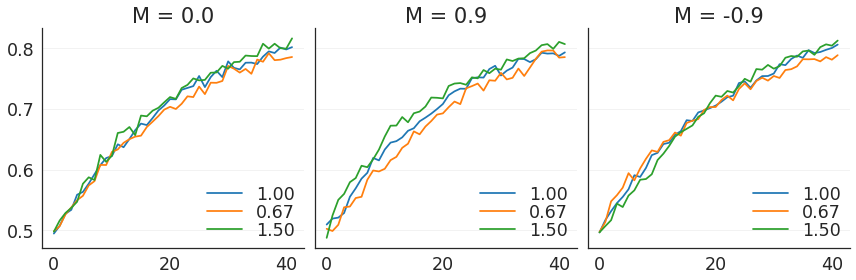

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
n_sim = 5000
n_subj = 3
n_mood = 3
n_trials = 42

## Define agents.
agents = [MoodyAgent(beta=9, eta_v = 0.08, eta_h=0.2, f=1.0),
          MoodyAgent(beta=9, eta_v = 0.08, eta_h=0.2, f=0.67),
          MoodyAgent(beta=9, eta_v = 0.08, eta_h=0.2, f=1.5)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
Y = np.zeros((n_sim, n_subj, n_mood, n_trials))

for i in np.arange(n_sim):

    ## Simulate block of game.
    X, R = slot_machine_game(n_trials=n_trials, reward=1)
    
    for j, agent in enumerate(agents): 
    
        for k, mood in enumerate([0,0.9,-0.9]):

            ## Simulate behavior.
            Y[i,j,k], _ = agent.simulate(X,R,Q=0,M=mood)        
            
## Average over trials.
Y = Y.mean(axis=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

## Plot.
for i, ax, mood in zip(range(3),axes,[0,0.9,-0.9]):
    
    for arr, label in zip(Y[:,i,:], [1,0.67,1.5]):
        
        ax.plot(arr, label='%0.2f' %label)
        
    ax.set(title='M = %0.1f' %mood)
    ax.legend(loc=4, borderpad=0, labelspacing=0)
    ax.grid(axis='y', alpha=0.25, zorder=0)
    
sns.despine()
plt.tight_layout()

**Figure 5:** Mood-bias can improve task performance. The simulated agents above were exposed to 1000 plays of the slot machine game. The canonical and mood-bias RL model had identical inverse temperature and learning rate parameters ($\beta = 15, \eta_v=0.10$) but differed in their reward history and bias parameters. Both agents were initialized at $EV = 0$ and $m = 0$.